# Plotting epi parameter estimates from bayesian logistic growth model 

### setup

In [1]:
library(ggplot2)
library(tidyverse)
library(RColorBrewer)
library(magrittr)
library(lubridate)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   0.3.5      
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [714]:
my_theme <- function() {
    theme_classic() +
    theme( 
        plot.title = element_text(color="black", size=12, face="bold"),
        axis.title.x = element_text(color="black", size=16, face="bold"),
        axis.title.y = element_text(color="black", size=16, face="bold", vjust=-2),
      #  axis.text.x = element_text(size= 10, vjust=0.5),
      #  axis.text.y = element_text(size = 10),
        axis.text=element_text(size=18),
        )
}

options(repr.plot.width=14, repr.plot.height=8)

## posterior distribution of netau under logistic growth model 

### Read in TSV 

In [3]:
path <- '/Users/nashwa/Desktop/git/hmpxv_dynamics/out/logistic/'
netau <- read.table(paste0(path,'logistic_growth_t50.tsv'), sep='\t', header=T)
head(netau)

,time,date,datetime,milliseconds,mean,median,upper,lower
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022.797,2022-10-18,2022-10-18T08:00:00,1.666080e+12,25.31316,20.31142,49.88838,11.43242
2,2022.790,2022-10-15,2022-10-15T18:05:03,1.665857e+12,24.82678,20.29794,49.80448,11.43185
3,2022.783,2022-10-13,2022-10-13T04:10:06,1.665634e+12,24.45672,20.27839,49.49118,11.43120
4,2022.776,2022-10-10,2022-10-10T14:15:09,1.665411e+12,24.15676,20.24913,49.10957,11.43046
5,2022.769,2022-10-08,2022-10-08T00:20:12,1.665188e+12,23.90278,20.22491,48.70991,11.42962
6,2022.762,2022-10-05,2022-10-05T10:25:15,1.664966e+12,23.68077,20.21632,48.39194,11.42868


In [53]:
# format date 
netau <- netau %>% mutate(month = months(as.Date(datetime)))
netau <- netau %>% mutate(datetime = as_date(date))

In [50]:
## specify the 15th of each/every other month? 

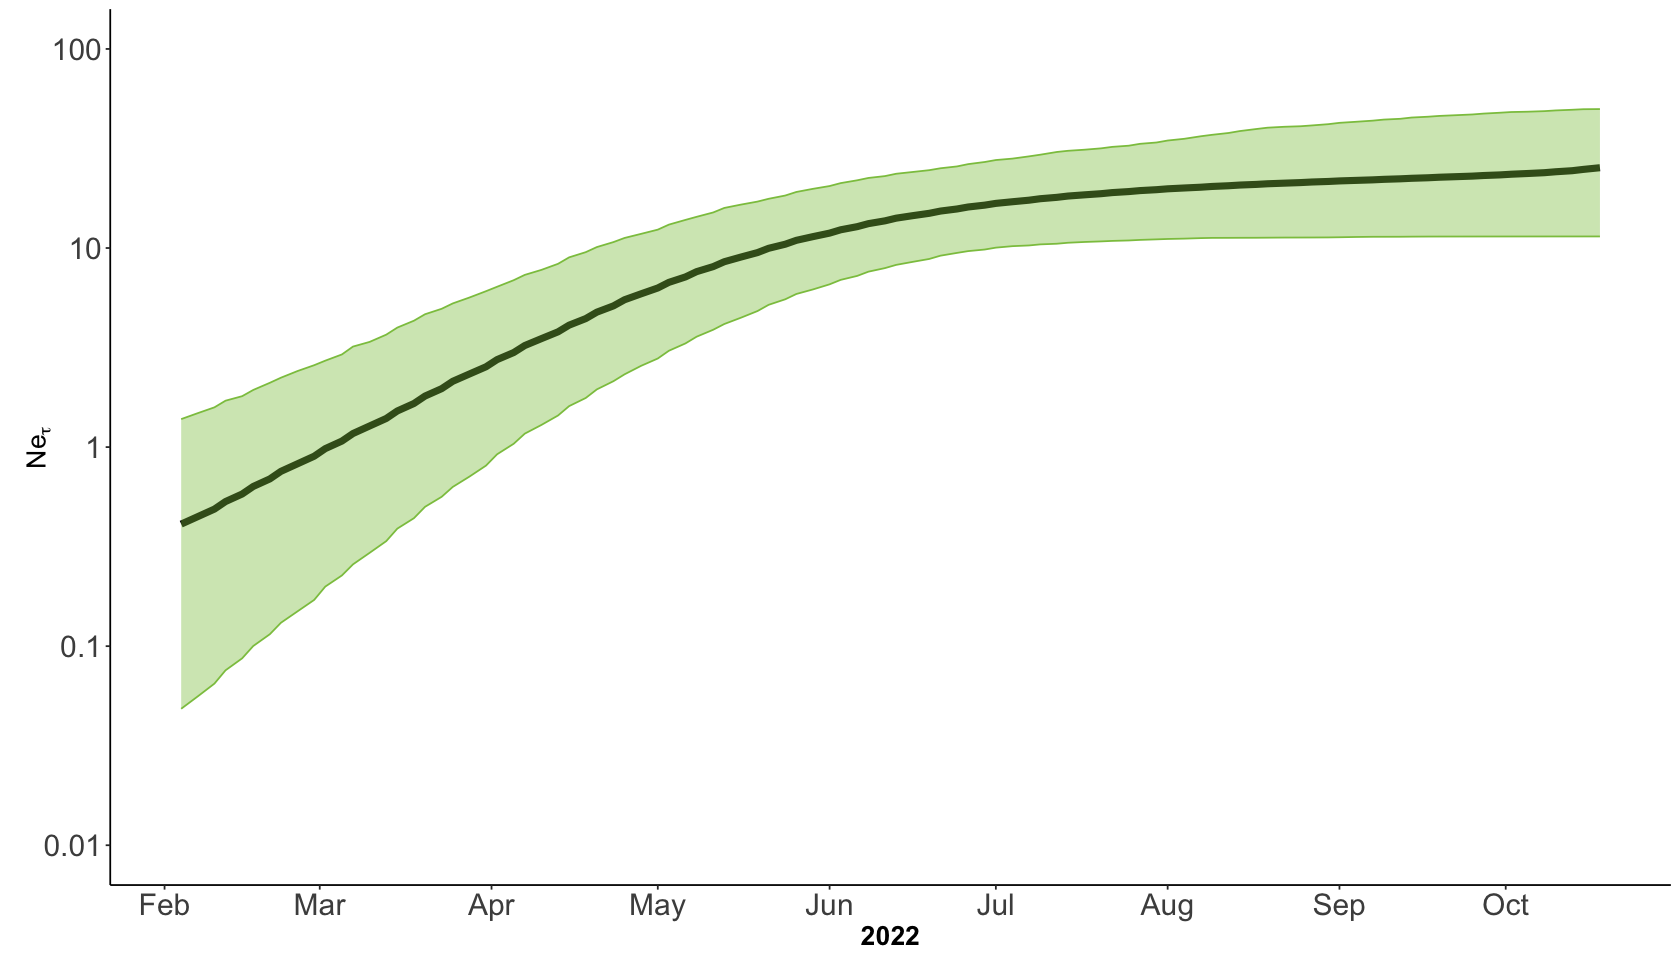

In [718]:
plot_netau <- netau %>% ggplot(aes(x=datetime, y=mean)) + 
         geom_line(size=2, color='black') +
         geom_ribbon(aes(ymin=lower, ymax=upper), color=rgb(0.55,0.77,0.3), alpha=0.4, fill=rgb(0.55,0.77,0.3)) +
         ylab(bquote(Ne[tau])) + xlab('2022') + 
         scale_y_continuous(trans='log10', breaks=c(.01, .1, 1, 10, 100), limits=c(.01,100), labels=c( .01, .1, 1, 10, 100)) +
         scale_x_date(date_labels = "%b", date_breaks='months') +
         my_theme()       

plot_netau

#ggsave('netau_gg.png',width=14, height=8)

## Ne<sub>τ</sub> with TMRCA overlay

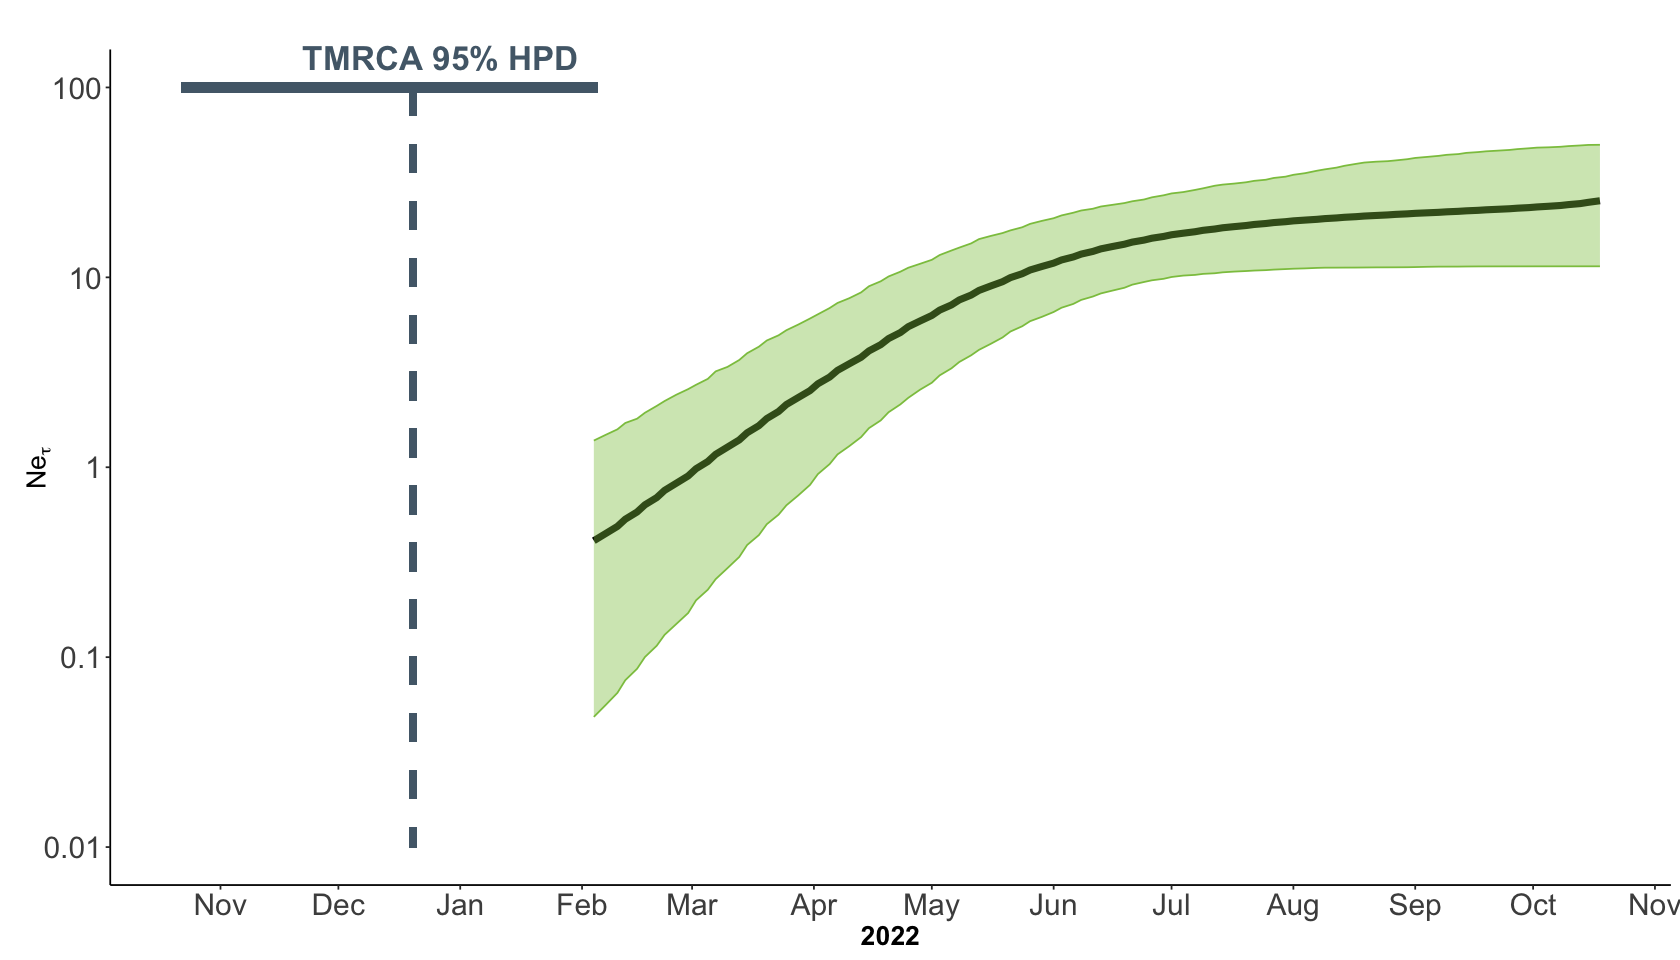

In [720]:
# tmrca estimates from BEAST
tmrca <- ymd('2021-12-20')
tmrca_upper <- ymd('2022-02-05')
tmrca_lower <- ymd('2021-10-22')
plot_netau + geom_segment(aes(x = tmrca_lower, y = 100, yend=100, xend=tmrca_upper),
                          size=3, color='#536878') +
             geom_segment(aes(x=tmrca, xend=tmrca, y=100, yend=0.01),
                          size=2, color='#536878', linetype='dashed') +
             ggtitle(label = 'TMRCA 95% HPD') + theme(plot.title = element_text(size = 20, hjust=.15, vjust=-4, color='#536878'))

#ggsave('netau_tmrca.png', width=14, height=8)


## Deriving Ne from logistic Netau

### SIR dynamics: 

per-day rate of increase (r) = contact rate (β) - recovery rate (γ)

β = r + γ

... 

According to WHO, hmpxv1 incubation period is 5-21 days.  
Early in the pandemic, S = 1, so generation time is inferred from contact rate alone. 

Thus, τ = 1 / (2 β)

In [ ]:
r_mean = 14.4011/365 #r per day
gamma <- 1/21 # recovery rate per day where infection length is 21 days 
beta <- r_mean + gamma #contact rate
tau_early <- (1/(2*beta)) / 365 #tau in years 

### Plot logistic Ne 

Maybe tau_early isn't sufficient for capturing info re: later stages of the outbreak.

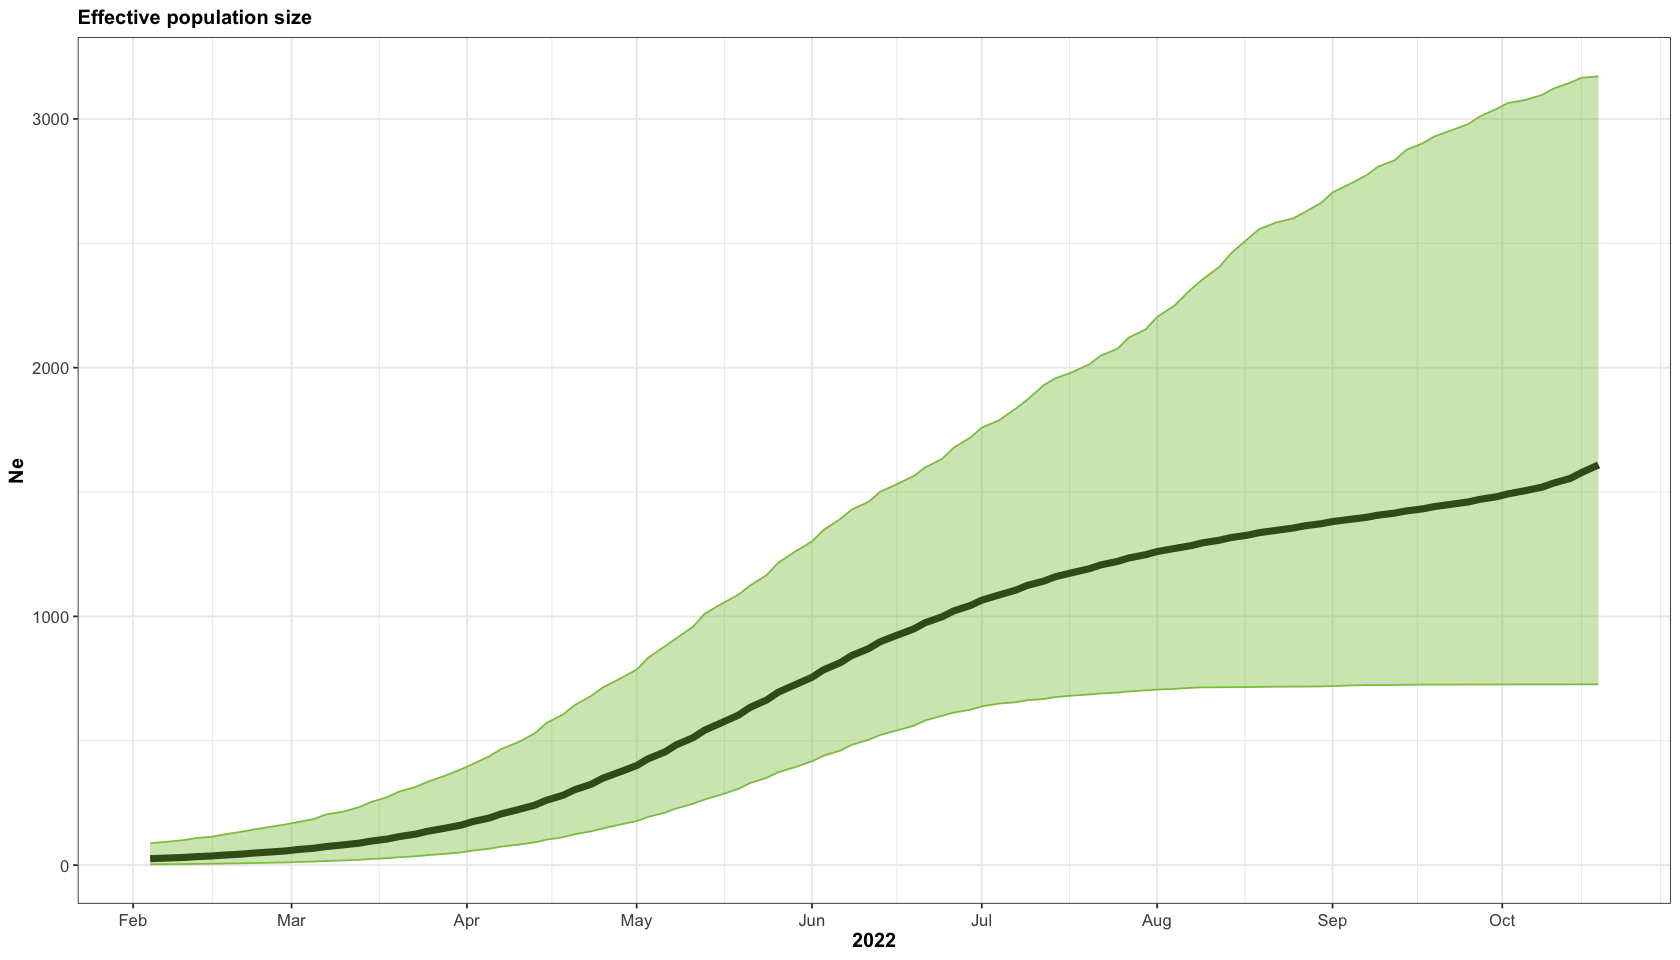

In [627]:
plot_ne_logistic <- netau %>% mutate(ne = mean/tau_early, 
                 ne_lower = lower/tau_early,
                 ne_upper = upper/tau_early) %>% 
          ggplot(aes(x=datetime, y=ne)) +
          geom_line(size=2, color='black') +
          geom_ribbon(aes(ymin=ne_lower, ymax=ne_upper), color=rgb(0.55,0.77,0.3), alpha=0.4, fill=rgb(0.55,0.77,0.3)) +
          ylab('Ne') + xlab('2022') + ggtitle('Effective population size') + 
          scale_x_date(date_labels = "%b", date_breaks='months') +
          my_theme()

plot_ne_logistic_blank <- netau %>% mutate(ne = mean/tau_early, 
                 ne_lower = lower/tau_early,
                 ne_upper = upper/tau_early) %>% 
          ggplot(aes(x=datetime, y=ne)) +
          geom_line(size=2, color='black') +
          geom_ribbon(aes(ymin=ne_lower, ymax=ne_upper), color=rgb(0.55,0.77,0.3), alpha=0.4, fill=rgb(0.55,0.77,0.3)) +
          ylab('') + xlab('2022') + 
          scale_x_date(date_labels = "%b", date_breaks='months') +
          theme(axis.text=element_text(size=18),
          axis.title=element_text(size=16,face="bold"),
          panel.grid.minor.x = element_line(),
          panel.border     = element_blank(),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          strip.background = element_rect(fill = "white", colour = "black", linewidth = rel(2)),
          axis.line = element_line(colour = "black", linewidth = rel(1)),
          legend.key = element_blank(),
          panel.background = element_rect(fill = "white", colour = NA))

plot_ne_logistic

### Read in Marlin's global case incidence estimates 

In [68]:
rtpath <- '/Users/nashwa/Desktop/git/hmpxv_dynamics/case-rt-analysis/estimates/'

incidence <- read.table(paste0(rtpath,'case-incidence-estimates.tsv'), sep='\t', header=T)
rts <- read.table(paste0(rtpath,'case-rt-estimates.tsv'), sep='\t', header=T)

incidence <- incidence %>% filter(location=='World') %>% mutate(datetime = as_date(date))
rts <- rts %>% filter(location=='World') %>% mutate(datetime = as_date(date))

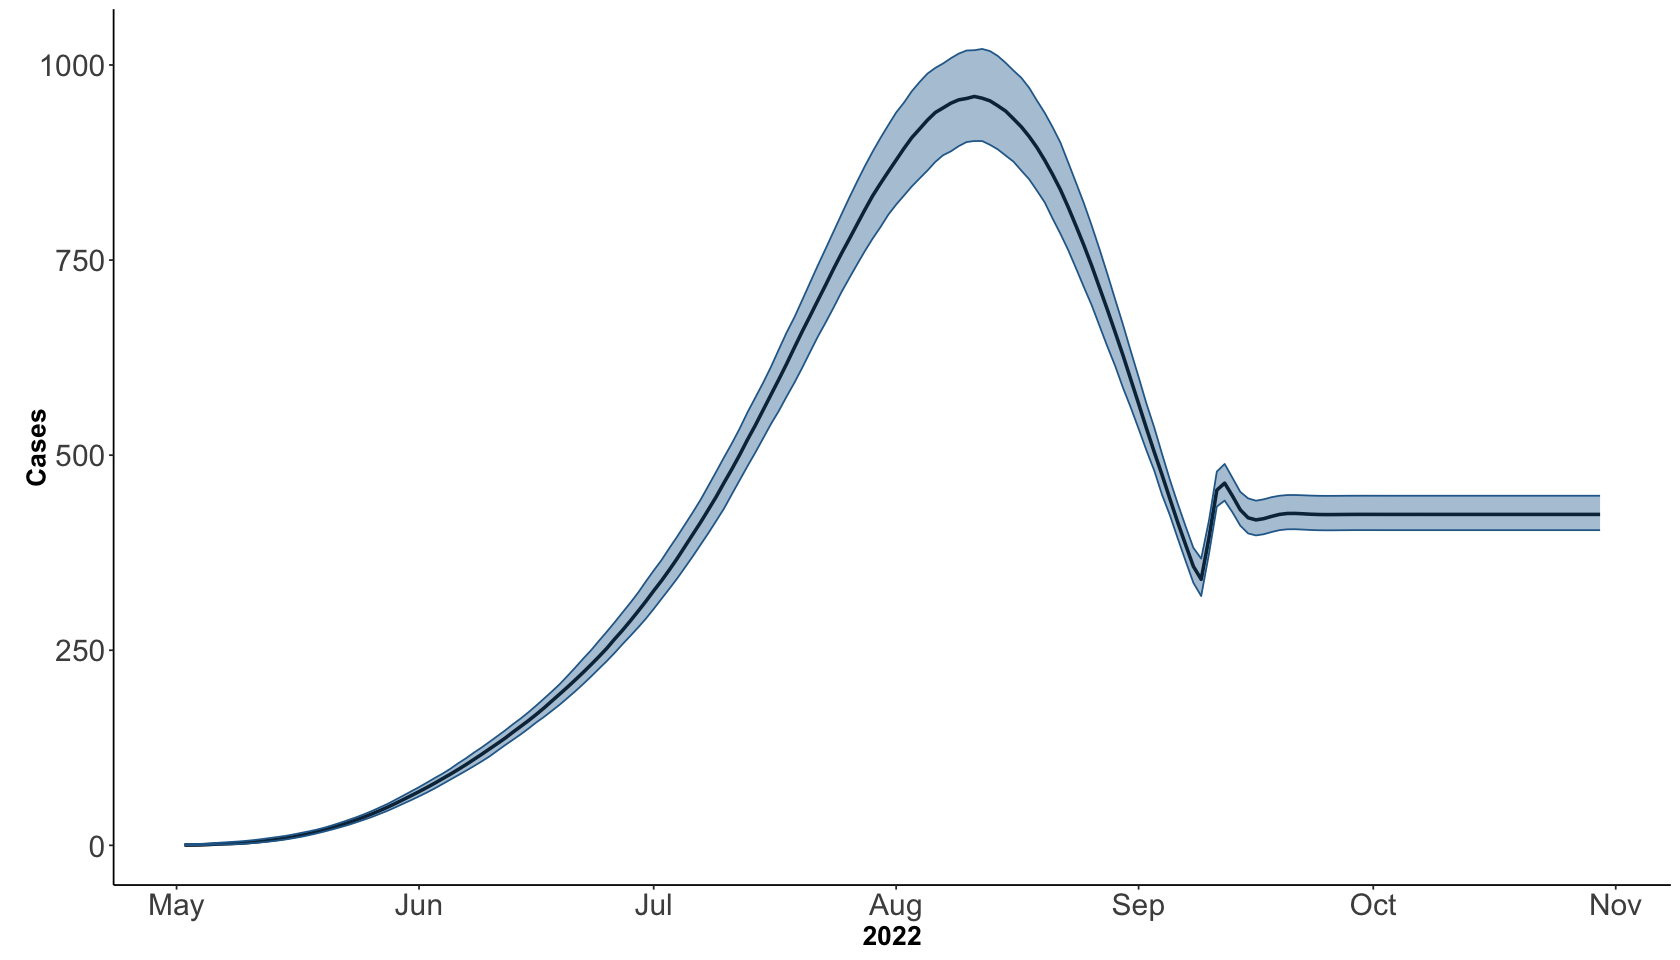

In [716]:
plot_incidence <- incidence %>% ggplot(aes(x=datetime, y=median_I_smooth, group=1)) +
              geom_line(linewidth=1, color='black') +
              geom_ribbon(aes(ymin=I_smooth_lower_80, ymax=I_smooth_upper_80), 
                          color=rgb(0.15,0.41,0.6), 
                          alpha=0.4, 
                          fill=rgb(0.15,0.41,0.6)) +
              ylab('Cases') + xlab('2022') +
              scale_x_date(date_labels = "%b", date_breaks='months') + 
              my_theme()

plot_incidence

#ggsave("incidence.png", width=14, height=8)


## Overlaying case incidence estimates with Ne estimates

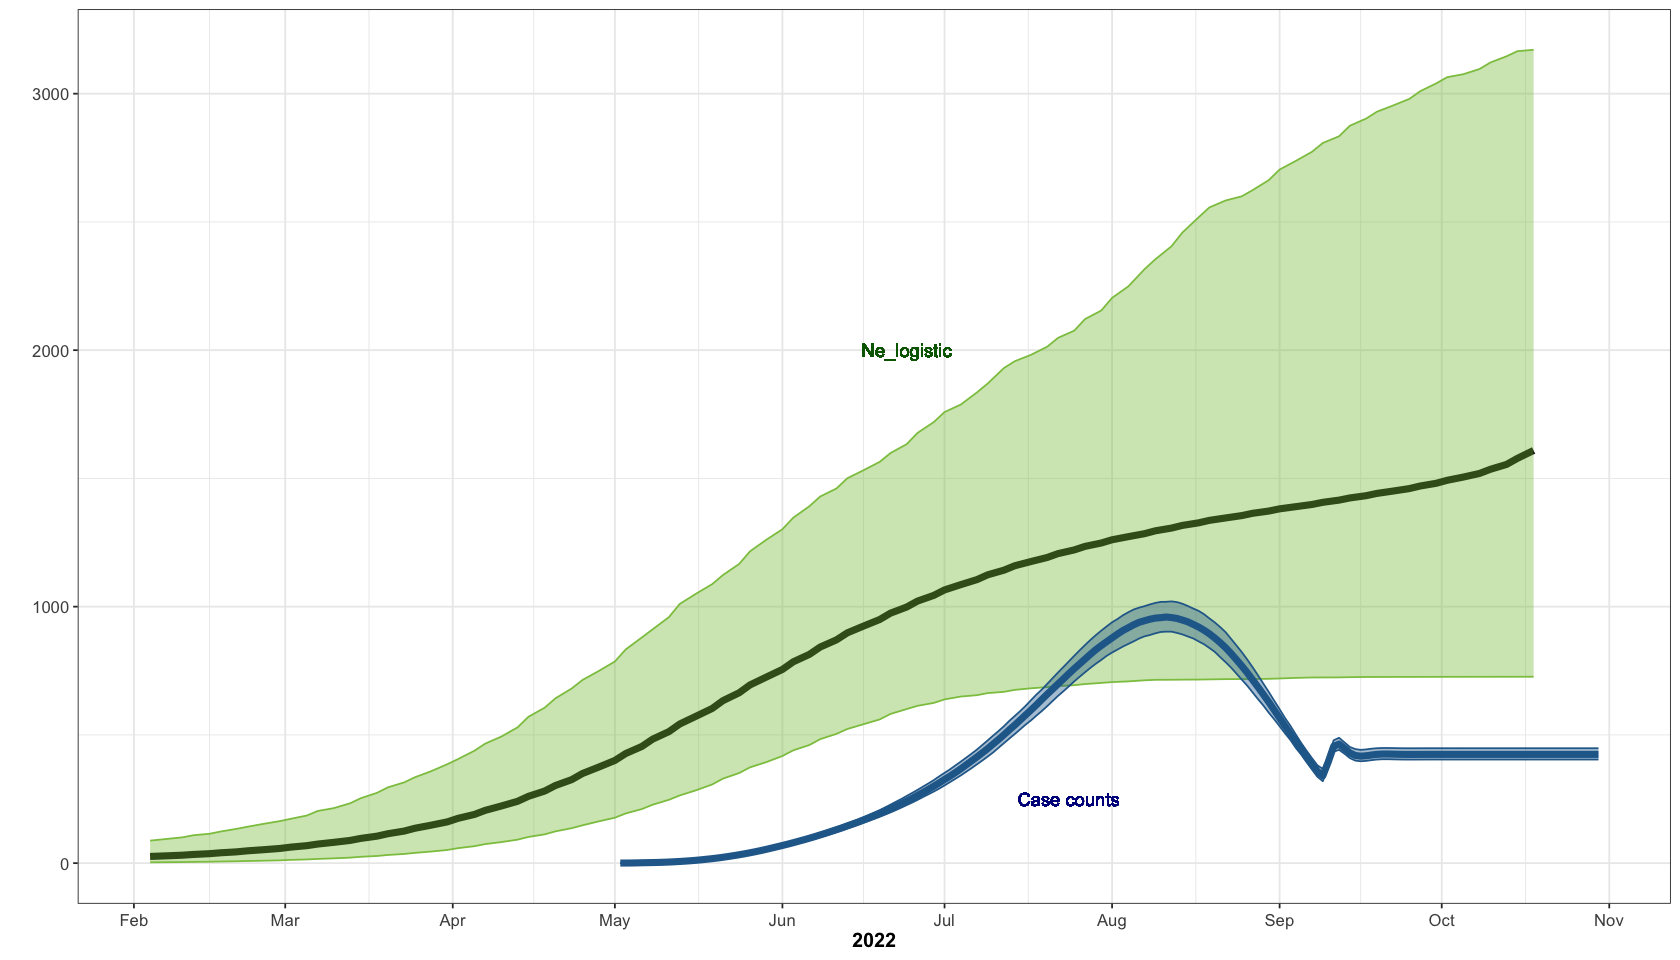

In [109]:
incidence2 <- incidence %>% mutate(ne=median_I_smooth,
                                   ne_lower=I_smooth_lower_80,
                                   ne_upper=I_smooth_upper_80)

plot_ne_logistic_blank + geom_line(data=incidence2, 
                             mapping=aes(x=datetime, y=median_I_smooth, group=1), 
                             linewidth=2,
                             color=rgb(0.15,0.41,0.6)) +
                         geom_ribbon(data=incidence2, mapping=aes(ymin=ne_lower, ymax=ne_upper),                                     
                                    color=rgb(0.15,0.41,0.6), 
                                    alpha=0.4, 
                                    fill=rgb(0.15,0.41,0.6)) +
                         geom_text(aes(x = as.Date('2022-06-24'),y=2000,label = "Ne_logistic"), color='darkgreen') +
                         geom_text(aes(x = as.Date('2022-07-24'),y=250,label = "Case counts"), color='darkblue') +
                         xlab('2022')
                            



## Skygrid analysis

### Read in log files

In [114]:
skgr_path <- '/Users/nashwa/Desktop/git/hmpxv_dynamics/out/skygrid/235_4hmpxv_skygrid.log'
skgr <- read.table(skgr_path, sep='\t', header=T)
head(skgr)

,state,joint,prior,likelihood,treeModel.rootHeight,age.root.,treeLength,skygrid.precision,skygrid.logPopSize1,skygrid.logPopSize2,⋯,frequencies1,frequencies2,frequencies3,frequencies4,alpha,clock.rate,meanRate,treeLikelihood,branchRates,skygrid
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,-42818.11,-8540.152,-34277.96,436.21282,1586.584,1598.2164,0.10000000,1.000000,1.000000,⋯,0.2500000,0.2500000,0.2500000,0.2500000,0.500000000,6.000000e-05,6.000000e-05,-34277.96,0,-8535.158
2,25000,-31932.75,-1725.432,-30207.32,41.30353,1981.494,2015.2986,0.09520051,6.320716,14.041650,⋯,0.3382135,0.1662366,0.1654492,0.3301007,0.040004133,1.388478e-05,1.388478e-05,-30207.32,0,-1715.805
3,50000,-31572.47,-1547.396,-30025.07,18.38270,2004.415,1043.5124,5.79204499,5.461820,5.075403,⋯,0.3321412,0.1665711,0.1662320,0.3350557,0.006690492,2.487801e-05,2.487801e-05,-30025.07,0,-1534.847
4,75000,-31232.82,-1513.901,-29718.92,25.50021,1997.297,967.2978,6.47413120,5.486094,5.603931,⋯,0.3367626,0.1644035,0.1655770,0.3332570,0.020605187,2.504249e-05,2.504249e-05,-29718.92,0,-1501.384
5,100000,-30963.35,-1482.394,-29480.96,17.43847,2005.359,848.9631,2.60577440,5.221602,4.623229,⋯,0.3370359,0.1686483,0.1681109,0.3262049,0.019163009,2.646684e-05,2.646684e-05,-29480.96,0,-1470.932
6,125000,-30857.32,-1477.107,-29380.21,16.47747,2006.320,832.1952,48.16919358,5.323956,5.296249,⋯,0.3291576,0.1675452,0.1673075,0.3359897,0.013611338,2.719332e-05,2.719332e-05,-29380.21,0,-1463.680


# epidemic growth rate r

In [366]:
# import case count data 
cc_path <- '/Users/nashwa/Desktop/git/hmpxv_dynamics/case-rt-analysis/data/monkeypox-cases-counts.tsv'
cc <- read.table(cc_path, sep='\t', header=T)
cc <- cc %>% mutate(datetime = as_date(date)) %>% 
                    filter(location == 'World') %>%
                    mutate(log_cases = log(cases)) %>% 
                    mutate(log_cases = case_when(log_cases < 0 ~ 0,
                                           log_cases >=0 ~ log_cases))
head(cc)

,location,date,cases,datetime,log_cases
,<chr>,<chr>,<dbl>,<date>,<dbl>
1,World,2022-05-02,0,2022-05-02,0
2,World,2022-05-03,0,2022-05-03,0
3,World,2022-05-04,0,2022-05-04,0
4,World,2022-05-05,0,2022-05-05,0
5,World,2022-05-06,0,2022-05-06,0
6,World,2022-05-07,1,2022-05-07,0


### linear regression on log transformed case counts
r = 0.0496 per day == 14.0 day doubling time

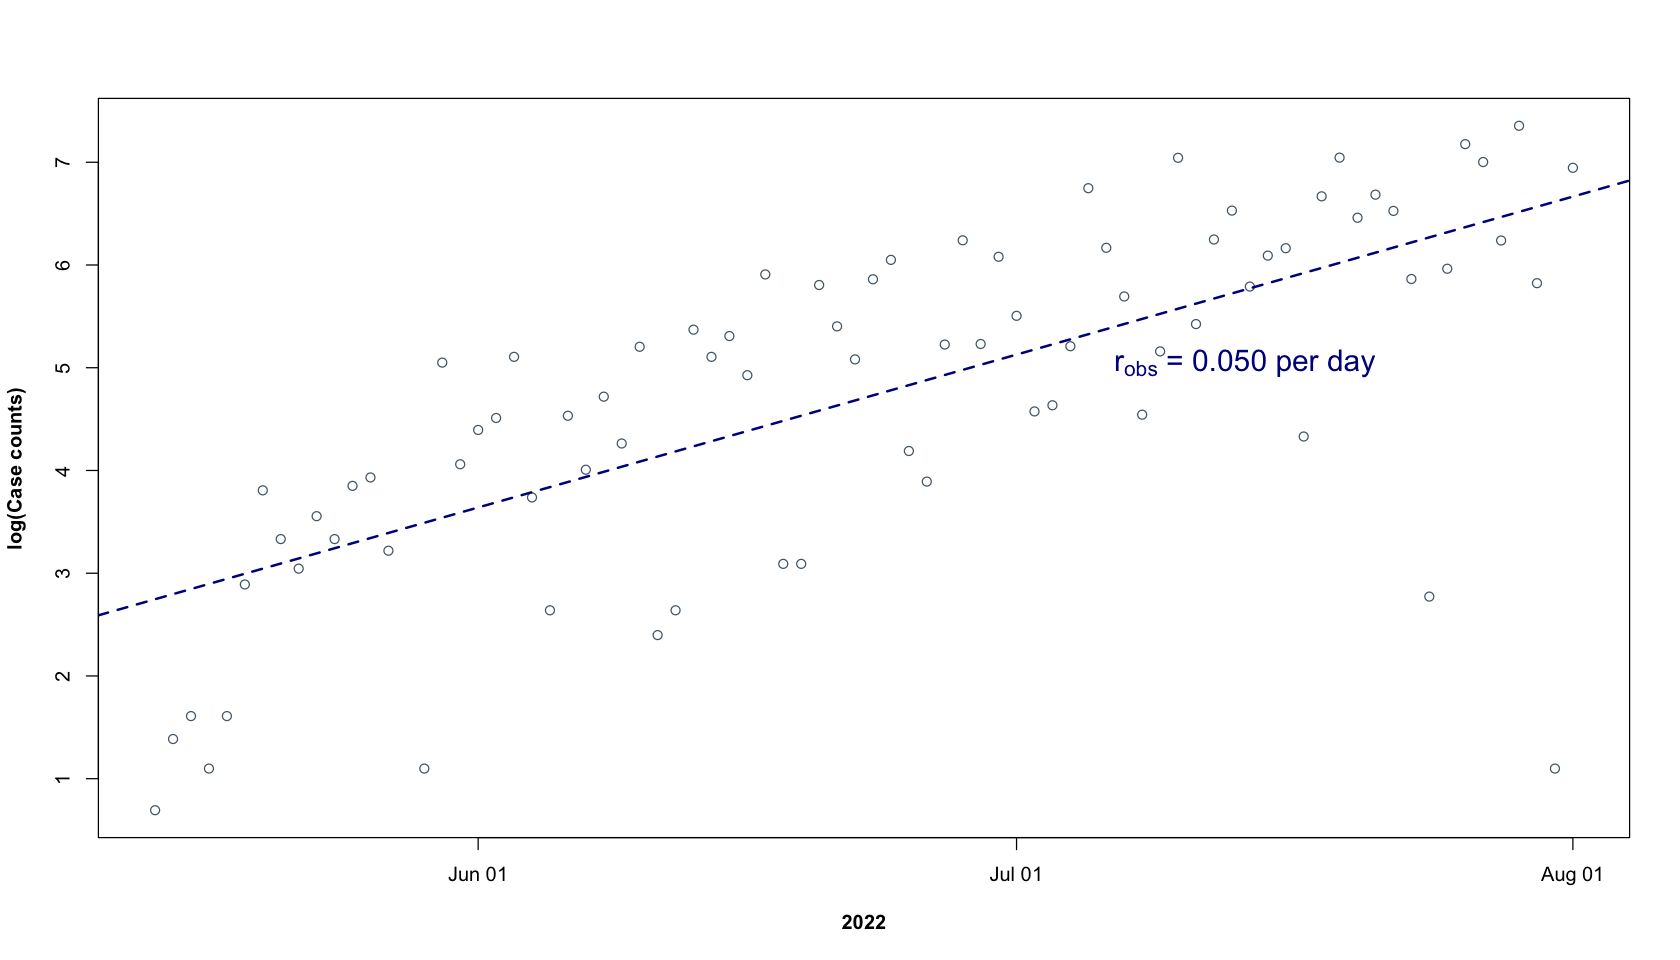

In [623]:
cc_early <- cc %>% 
            mutate(decimal = decimal_date(datetime)) %>%
            filter(decimal <= 2022.581) %>% # 2022-05-14 - 2022-08-01 
            filter(log_cases > 0)

lm.cc_early <- lm(log(cc_early$cases) ~ datetime, data=cc_early)

#png("r_cases.png", width=500, height=350)
plot(y=cc_early$log_cases, 
     x=cc_early$datetime,
     #main="Global", 
     xlab='2022', 
     ylab='log(Case counts)',
     col='#536878',
     font.lab = 2)
title(expression(paste('r'[obs],' = 0.050 per day')), line = -11, adj=0.8, cex.main=1.25, col.main='darkblue', cex.main=1.5)
#title(expression(paste('r'[est],' = 0.0395 per day')), line = -7, adj=0.1, cex.main=1.5)

abline(lm.cc_early, col='darkblue', lty=2, lwd=2)
#dev.off()


### compare to logistic growth rate r <sub>est

weird looking logistic_r line

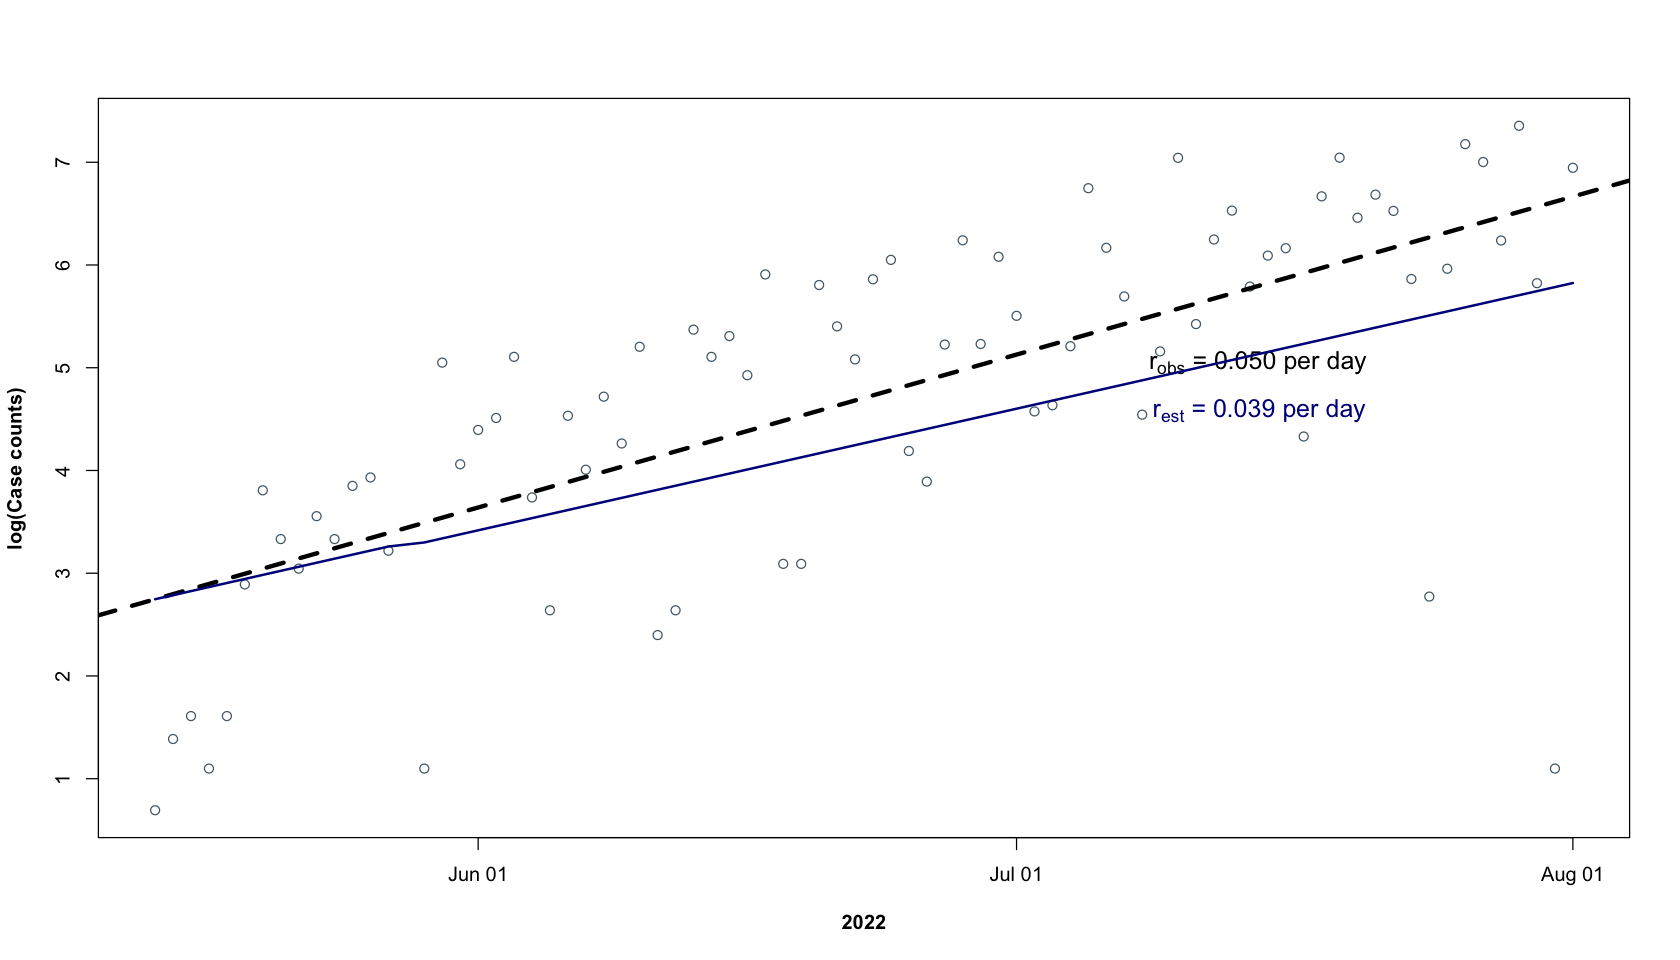

In [624]:
logistic_r <- 0.03945506849315068 #via BEAST 
r_overlay <- tibble(datetime=cc_early$datetime) %>% 
              mutate(x=0:(length(datetime)-1)) %>%
            # mutate(y=logistic_r) %>%
              mutate(z=lm.cc_early$fitted.values[1]) %>%
              mutate(infections=case_when(
                          x == 0 ~ z, 
                          x >= 1 ~ logistic_r*x + z))
#png('r_overlay.png', width=500, height=350)
plot(y=cc_early$log_cases, 
     x=cc_early$datetime,
     #main="Global", 
     xlab='2022', 
     ylab='log(Case counts)',
     col='#536878',
     font.lab = 2)
title(expression(paste('r'[obs],' = 0.050 per day')), line = -11, adj=0.8, cex.main=1.25)
title(expression(paste('r'[est],' = 0.039 per day')), line = -13, adj=0.8, cex.main=1.25, col.main='darkblue')
abline(lm.cc_early, lty=2, lwd=3.5)
lines(x=r_overlay$datetime, y=r_overlay$infections, lwd=2, col='darkblue')
#dev.off()


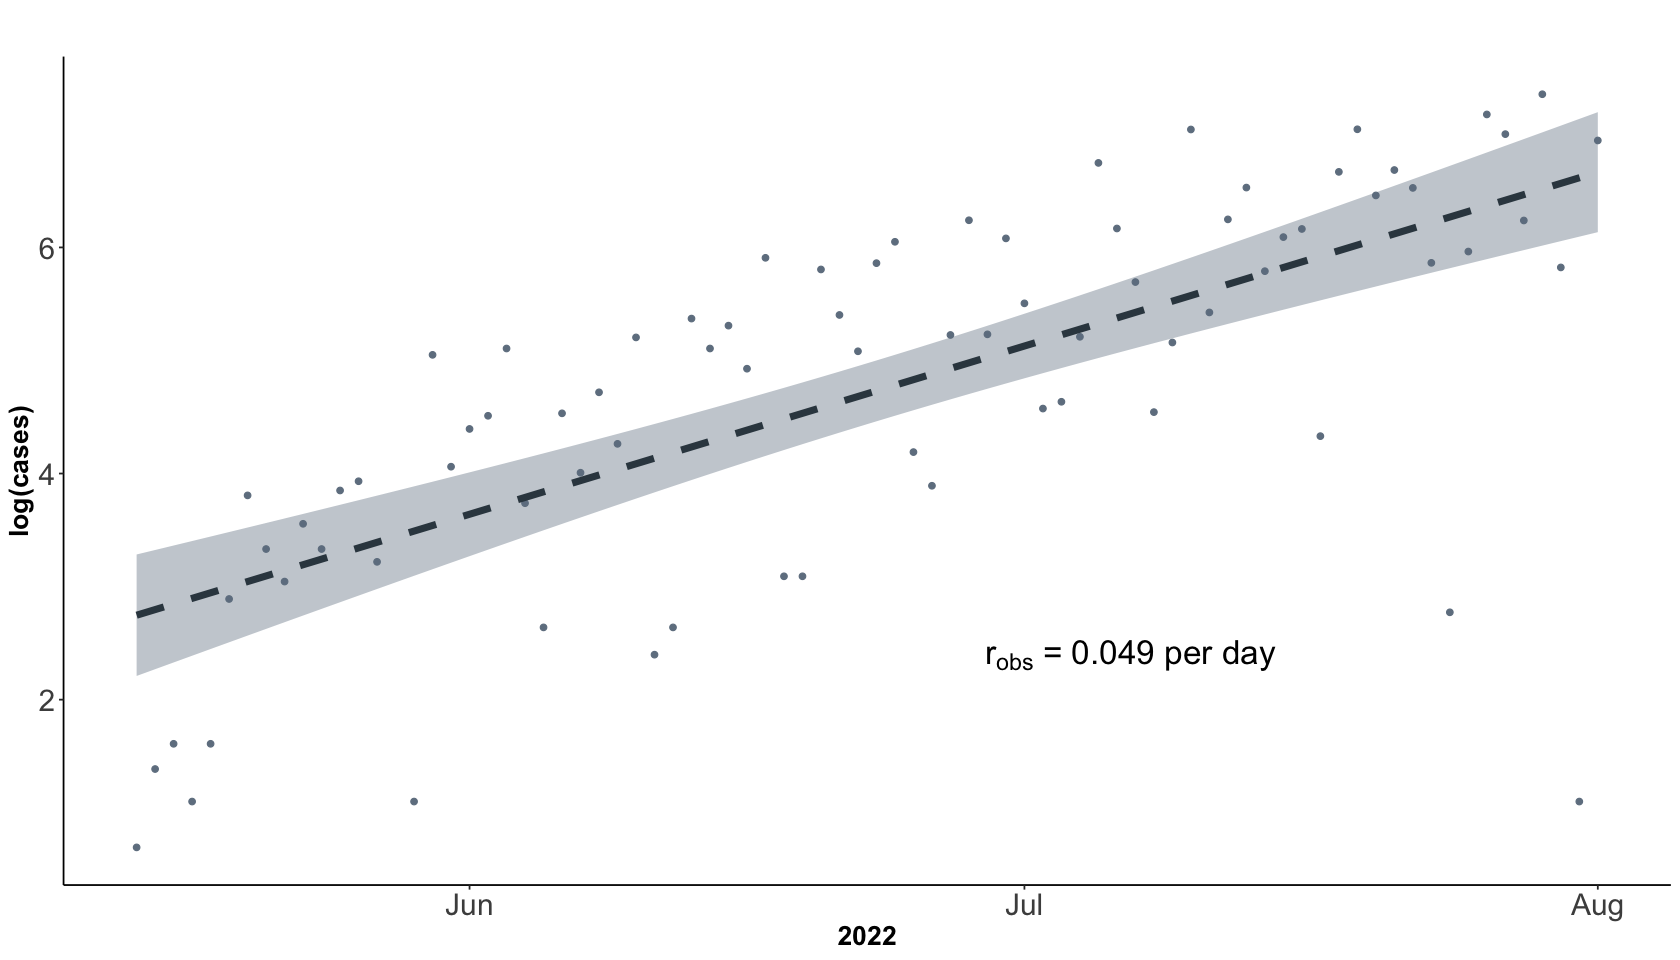

In [622]:
ggplot(cc_early, aes(x=datetime, y=log_cases)) + 
    geom_point(color='#708090') + 
    stat_smooth(method = "lm", #,se=False,
                formula = y ~ x, 
                fill='#708090', 
                color='#36454f',
                size=2,
                linetype = "dashed") + 
    ylab('log(cases)') + xlab('2022') + 
    ggtitle(label = expression(paste('r'[obs],' = 0.049 per day'))) + 
    theme(plot.title = element_text(size = 20, vjust = -85, hjust=.7),
          plot.subtitle = element_text(size = 20, color = "#a64d79", vjust = -88,hjust = .7),
          axis.text=element_text(size=18),
          axis.title=element_text(size=16,face="bold"),
          panel.grid.minor.x = element_line(),
          panel.border     = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          strip.background = element_rect(fill = "white", colour = "black", linewidth = rel(2)),
          axis.line = element_line(colour = "black", linewidth = rel(1)),
          legend.key = element_blank(),
          panel.background = element_rect(fill = "white", colour = NA)) 

#ggsave("r_cases_gg.png", width=14, height=8)

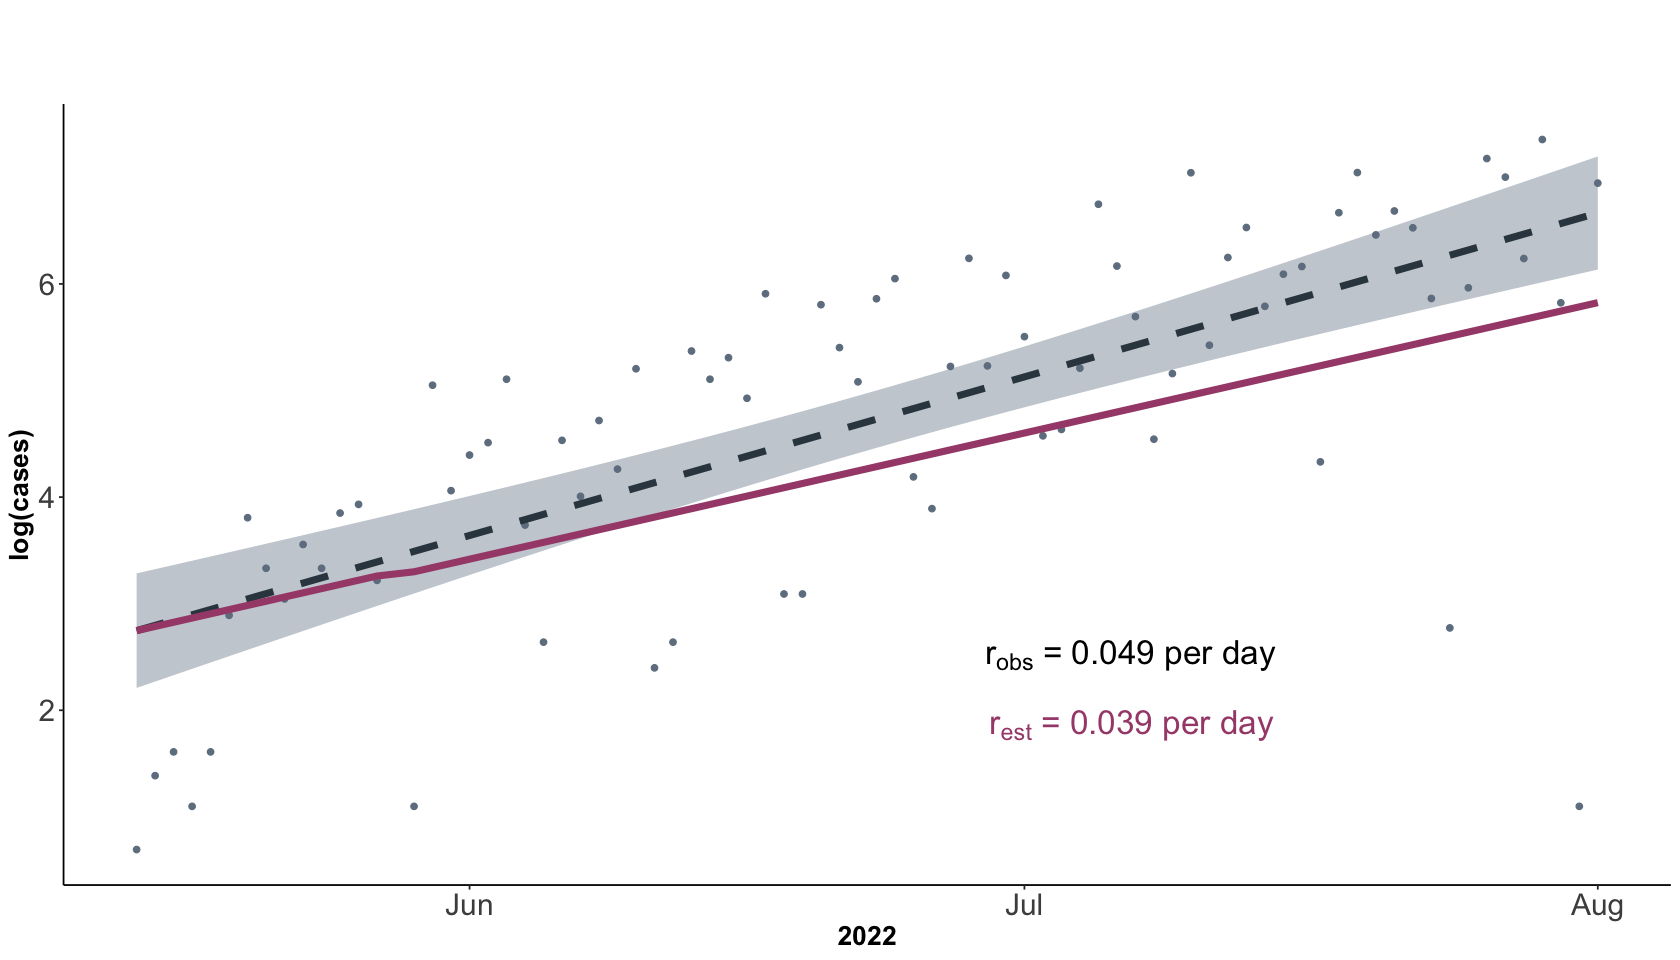

In [621]:
ggplot(cc_early, aes(x=datetime, y=log_cases)) + 
    geom_point(color='#708090') + 
    stat_smooth(method = "lm", #,se=False,
                formula = y ~ x, 
                fill='#708090', 
                color='#36454f',
                size=2,
                linetype = "dashed") + 
    ylab('log(cases)') + xlab('2022') + 
    ggtitle(subtitle=expression(paste('r'[est],' = 0.039 per day')), label = expression(paste('r'[obs],' = 0.049 per day'))) + 
    geom_line(data=r_overlay, mapping=aes(x=datetime, y=infections), size=2, color='#a64d79') +
    theme(plot.title = element_text(size = 20, vjust = -85, hjust=.7),
          plot.subtitle = element_text(size = 20, color = "#a64d79", vjust = -88,hjust = .7),
          axis.text=element_text(size=18),
          axis.title=element_text(size=16,face="bold"),
          panel.grid.minor.x = element_line(),
          panel.border     = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          strip.background = element_rect(fill = "white", colour = "black", linewidth = rel(2)),
          axis.line = element_line(colour = "black", linewidth = rel(1)),
          legend.key = element_blank(),
          panel.background = element_rect(fill = "white", colour = NA)) 

#ggsave("r_overlay_gg.png", width=14, height=8)



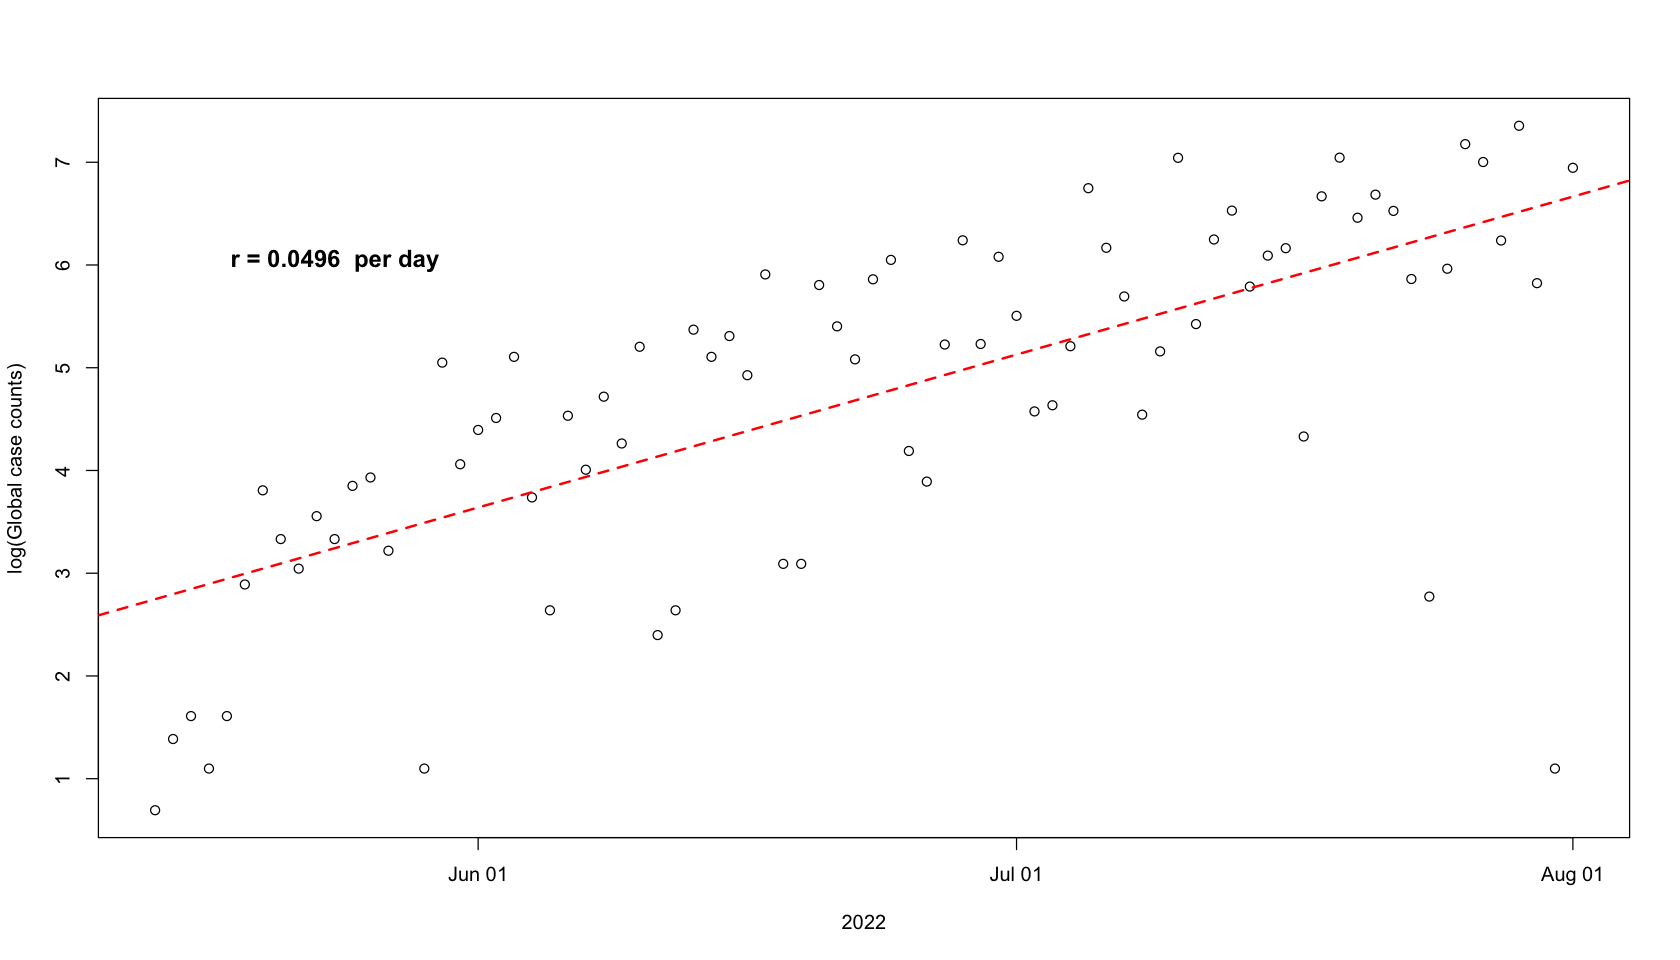

In [416]:
plot(y=cc_early$log_cases, 
     x=cc_early$datetime,
     xlab='2022', 
     ylab='log(Global case counts)')
title(paste("r =",round(lm.cc_early$coefficients[2],4)," per day"), line = -7, adj=0.1)

locator()

abline(lm.cc_early, col='red', lty=2, lwd=2)
abline()


In [425]:
latest <- read.csv("https://raw.githubusercontent.com/globaldothealth/monkeypox/main/latest.csv")

Warning message in file(file, "rt"):
“cannot open URL 'https://raw.githubusercontent.com/globaldothealth/monkeypox/main/latest.csv': HTTP status was '404 Not Found'”


ERROR: Error in file(file, "rt"): cannot open the connection to 'https://raw.githubusercontent.com/globaldothealth/monkeypox/main/latest.csv'


## NOTES/WsIP

In [ ]:
## on side: phylo r; as text at least 

N (census) > Ne (effective pop size) // read theoretical phylo 
- random mixing, homog pops,
N < Ne 
-  superspreader; nonrandom/selective forces 

datetime 
0.04960473

ERROR: Error in exp(lm.cc_early): non-numeric argument to mathematical function


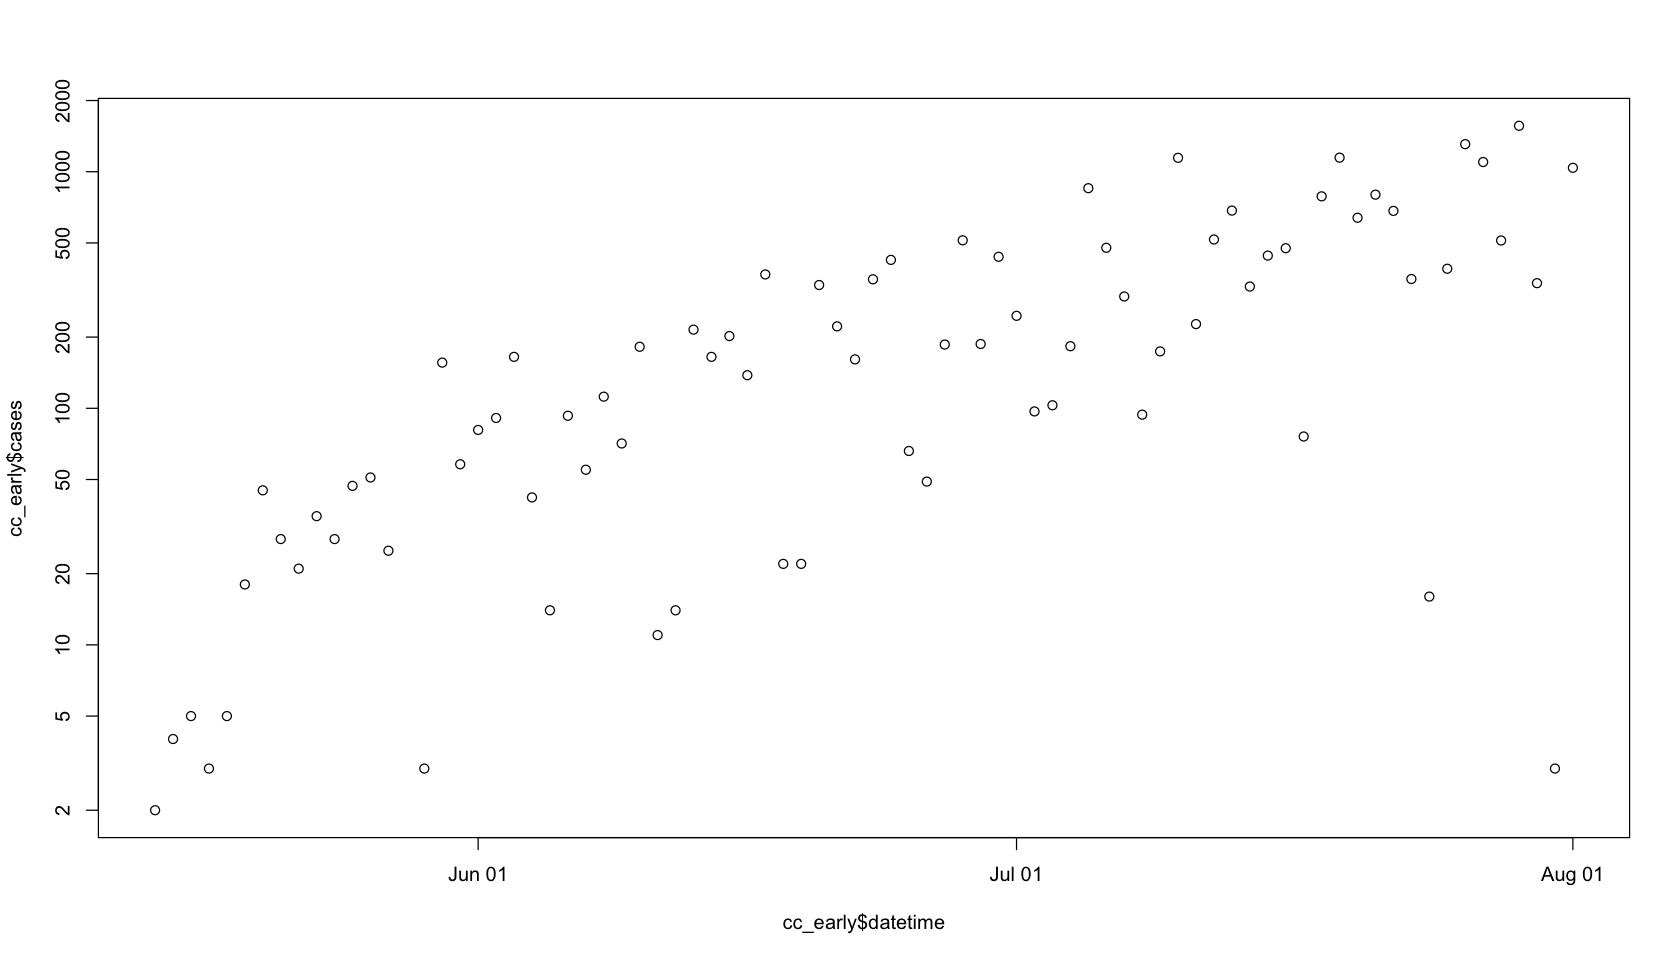

In [430]:
lm.cc_early$coefficients[2]

plot(y=cc_early$cases, 
    x=cc_early$datetime, log='y')
abline(lm.cc_early, col='red', lty=2, lwd=2)

datetime 
0.02020562

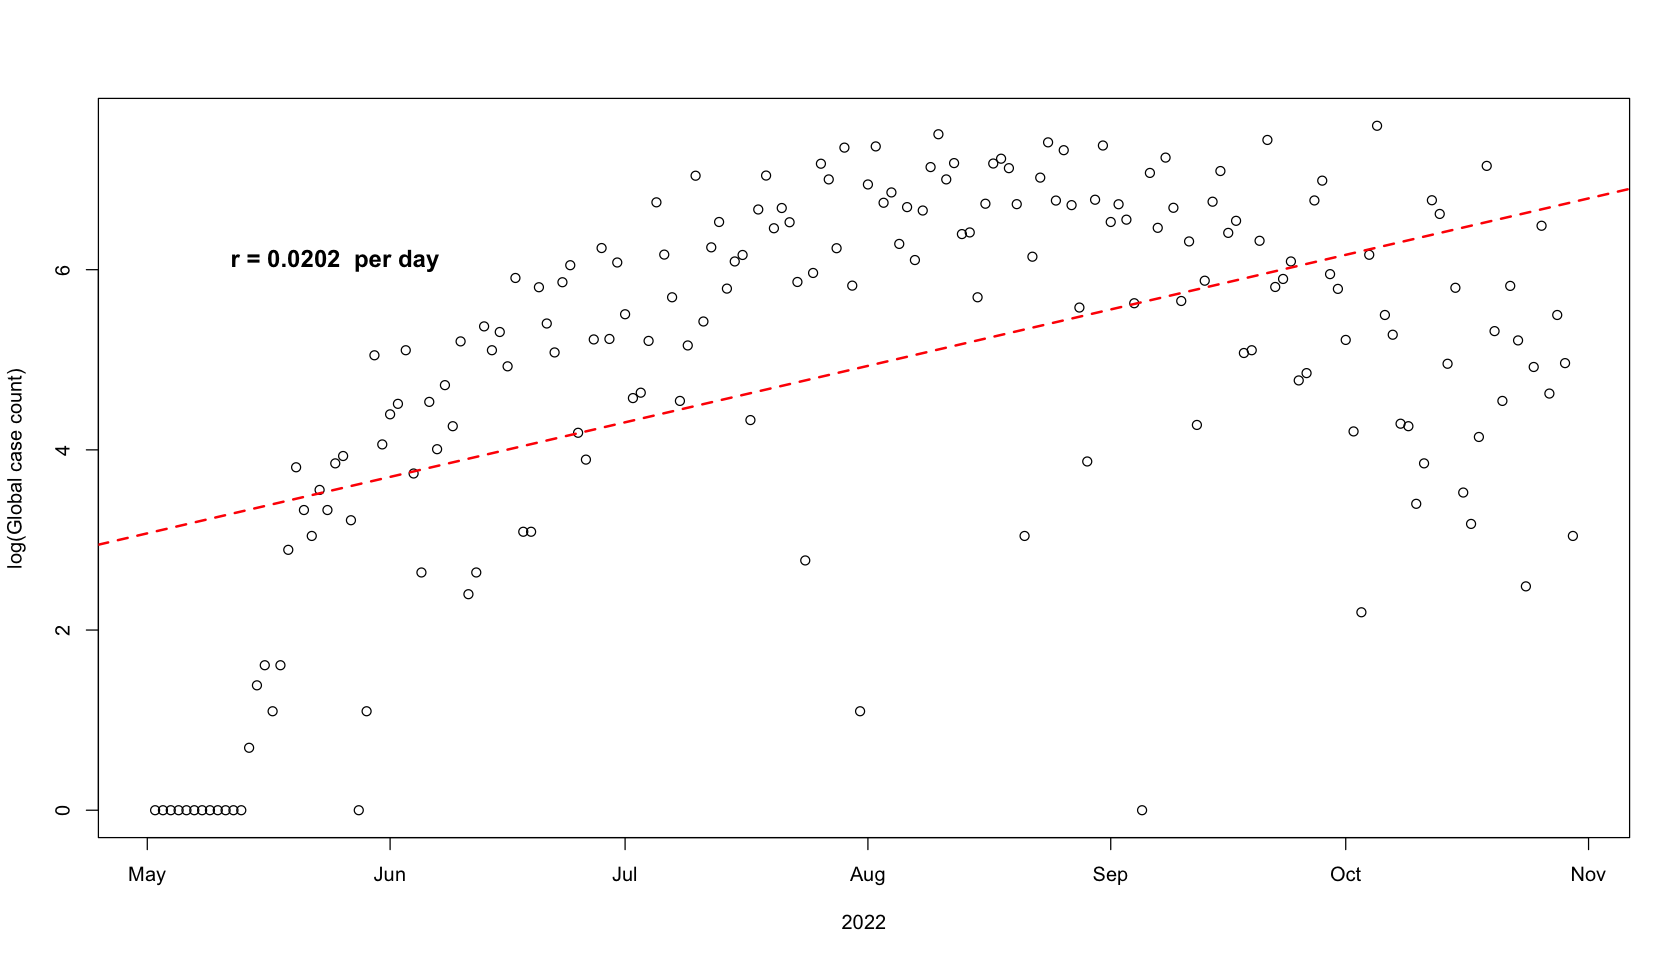

In [375]:
log.cc.lm <- lm(log_cases ~ datetime, data=cc)
plot(x=cc$datetime, y=cc$log_cases,
     xlab='2022', 
     ylab='log(Global case count)')
abline(log.cc.lm, col='red', lty=2, lwd=2)
title(paste("r =",round(log.cc.lm$coefficients[2],4)," per day"), line = -7, adj=0.1)
cc.r



exponential growth rate, tmrca post. distribs.

In [119]:
# parameter estimates via tracer
#k <- 25.3132
#r <- 0.039 # in years
#taut <- 0.016 # in yers 

Warning message:
“Removed 34 row(s) containing missing values (geom_path).”


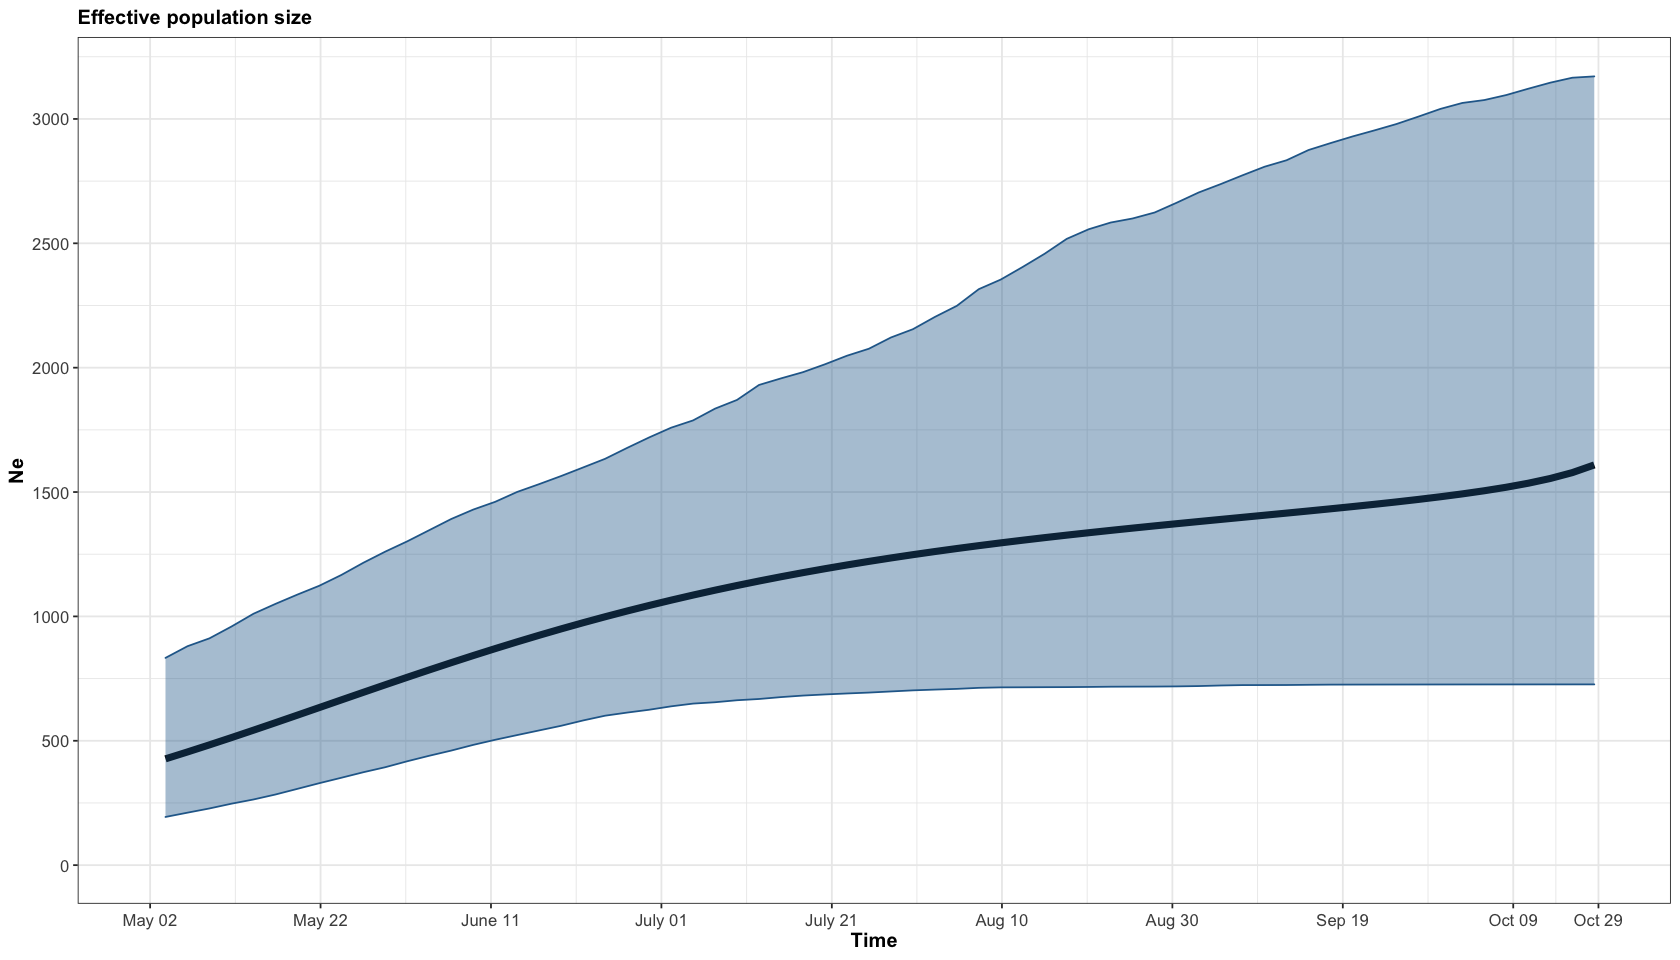

In [185]:
## do may 02 - oct 29

netau %>% mutate(ne = mean/tau_early, 
                 ne_lower = lower/tau_early,
                 ne_upper = upper/tau_early) %>% 
          ggplot(aes(x=datetime, y=ne)) +
          geom_line(size=2, color='black') +
          geom_ribbon(aes(ymin=ne_lower, ymax=ne_upper), color=rgb(0.15,0.41,0.6), alpha=0.4, fill=rgb(0.15,0.41,0.6)) +
          ylab('Ne') + xlab('') + ggtitle('Effective population size') + #xlim(c(2022.4, 2022.8)) +
          scale_x_continuous(limits=c(2022.3329,2022.7986), 
                             breaks=c(2022.3329, 2022.3877, 2022.4425, 2022.4973,
                                     2022.5521, 2022.6068, 2022.6616,2022.7164, 2022.7712, 2022.7986), 
                             labels=c('May 02','May 22','June 11','July 01', 'July 21',
                                      'Aug 10', 'Aug 30', 'Sep 19', 'Oct 09', 'Oct 29')) +
          scale_y_continuous(breaks=c(0, 500, 1000, 1500, 2000, 2500, 3000)) +
          my_theme()